## 1. Incremental constitutive law

### 1.1 Import dependencies

In [1]:
import pickle
import sympy as sym
import numpy as np
from scipy.integrate import solve_ivp
from progressbar import ProgressBar

import matplotlib.pyplot as plt
font = {'size'   : 12}
plt.rc('font', **font)

### 1.2 Sympy symbols

In [2]:
# Material parameters
E= sym.Symbol('K',real=True) # Bulk modulus
k = sym.Symbol('k',real=True) # Material strength in simple shear
s = sym.Symbol('s',real=True) # transition parameter (s>0, hypoplasticity -- s->\infty, hyperplasticity)

# Components
e = sym.Symbol('\epsilon',real=True)
de = sym.Symbol('\dot{e}}',real=True)
z = sym.Symbol('z',real=True)
dz = sym.Symbol('\dot{z}',real=True)
sg = sym.Symbol('\sigma',real=True)

# Arguments of lambdify functions
prms = [E, k, s]
args_s = [sg]
args_de = [de]
args = sym.flatten([sg, prms, de])

### 1.3 Compute stress and plastic strain increments

In [3]:
Zdot = sym.Abs(de)*sym.sign(sg)*(sym.Pow(sym.Abs(sg)/k,s))
Sdot = E*(de-sym.Abs(de)*sym.sign(sg)*(sym.Pow(sym.Abs(sg)/k,s)))
# Sdot_tensor = Sdot_tensor + 3*K*Edot_hyd

func_Zdot_tensor = sym.lambdify(args, Zdot)
func_Sdot_tensor = sym.lambdify(args, Sdot)

### 1.4 Build-in functions (numpy)

In [4]:
def calculate_energy(gamma_el,E):
    ''' Compute Helmholtz free energy '''
    
    F = 0.5*E*gamma_el**2
    return F  

def dissipation(stress,d_eps_pl):
    ''' Compute dissipation rate '''
    
    D=stress*d_eps_pl
    return D

### 1.5 Incremental constitutive relations

In [5]:
def incremental_constitutive(t,y,de,params):
    E, k, s = params
    sol_S = np.array(func_Sdot_tensor(y[0],
                                      params[0], params[1], params[2],
                                      de))
    sol_Z = np.array(func_Zdot_tensor(y[0],
                                      params[0], params[1], params[2],
                                      de))
    return np.array([sol_S,sol_Z]).flatten()

def perform_constitutive_increment(strain_increment, state, params):
    y0, t0 = state, 0.0
    tol_e = 1.e+3; tol_s = 1.e-3; gl_tol = 1.e-8
    statetdt = solve_ivp(fun=lambda t, y: incremental_constitutive(t,y,strain_increment,params),
                         t_span=[0.,1.],
                         y0 = y0,
                         method='RK23', rtol = 1.e-6,
                         atol = gl_tol * np.array([tol_s,tol_e])
                        )
    status = statetdt.success
    if status==False : print("solve_ivp didn't converge")
    return statetdt.y[:,-1:].flatten()

### 1.6 Refine and structure data 

In [6]:
def refine_structure_data(svars_tdt,params,increments):
    '''Refine the data and split in couple of states at time t and time t+dt'''
    
    E_param, k_param, s_param = params
    svars_t=np.array([svars_tdt[i-1] for i in range(0,increments)]); svars_t[0]=0.*svars_t[0]
    svars_t[np.arange(0,len(svars_t),n_reset)]=np.zeros(len(svars_tdt[0])) # svars at time t
    
    stress_t=svars_t[:,0]
    pl_strain_t=svars_t[:,1]
    strain_t=svars_t[:,2]
    
    stress_tdt=svars_tdt[:,0]
    pl_strain_tdt=svars_tdt[:,1]
    strain_tdt=svars_tdt[:,2]
    
    delta_pl_strain = pl_strain_tdt-pl_strain_t
    el_strain_t = strain_t-pl_strain_t
    el_strain_tdt = strain_tdt-pl_strain_tdt
    
    dissipation_rate_tdt = np.array([dissipation(stress_tdt[i],delta_pl_strain[i])
                                     for i in range(0,increments)])
    energy_tdt = np.array([calculate_energy(el_strain_tdt[i],E_param)
                           for i in range(0,increments)])
    return stress_t,stress_tdt,pl_strain_t,pl_strain_tdt,el_strain_t,el_strain_tdt,strain_t,strain_tdt,energy_tdt,dissipation_rate_tdt

## 2. Data generation

### 2.1 Material parameters

In [7]:
E_param = 200.e+3 # Young modulus
S_y = 200. # Material strength 
s = 1 # transition hypo-hyper parameter

params = [E_param, S_y/np.sqrt(2),s]

### 2.2 Increments and prescribed strain path

In [8]:
increments = 400 # number of increments
n_reset = 200 # number of increments before resetting

mod = 1e-4 # amplitude
deps_inc = np.zeros((increments))
for i in range(n_reset):
    deps_inc[i] = mod * np.sign(np.cos((2*i*np.pi)/(0.5*n_reset))) # first path
    deps_inc[n_reset+i] = 2*mod * np.sign(np.cos((2*i*np.pi)/(0.5*n_reset))) # second path

### 2.3 Generate data from prescribed strain path

In [9]:
epsilon_tdt=np.zeros((increments))
svars_tdt=np.zeros((increments,3)) # stress (0), plastic strain (1), total strain (2)  

tol=1e-24; # do not modify

pbar = ProgressBar()
for i in pbar(range(increments)):
    if not i % n_reset:
        svarsGP_t=np.zeros(3)+tol
          
    epsilon_tdt[i]=svarsGP_t[2]+deps_inc[i]
    svars_tdt[i,:2] = perform_constitutive_increment(deps_inc[i],svarsGP_t[:2],params)
    svars_tdt[i,2]=epsilon_tdt[i]
    svarsGP_t=svars_tdt[i]

print("Incrementation completed\nProcessing data")

Incrementation completed
Processing data


### 2.4 Restructure data

In [10]:
data = refine_structure_data(svars_tdt,params,increments)
stress_t,stress_tdt,pl_strain_t,pl_strain_tdt,el_strain_t,el_strain_tdt,strain_t,strain_tdt,energy_tdt,dissipation_rate_tdt = data

### 2.5 Plot data

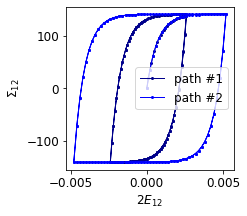

In [11]:
plt.rcParams["figure.figsize"] = (3,3)
fig, ax = plt.subplots(1)

ax.plot(strain_t[:n_reset], stress_t[:n_reset],
        marker='o',markersize=2, linewidth=1, color='darkblue',label='path #1')
ax.plot(strain_t[n_reset:], stress_t[n_reset:],
        marker='o',markersize=2, linewidth=1, color='blue',label='path #2')
ax.set_xlabel('$2E_{12}$')
ax.set_ylabel('$\Sigma_{12}$')
ax.legend()

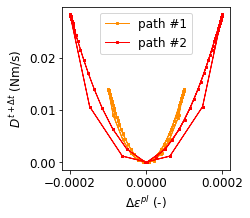

In [12]:
fig, ax = plt.subplots(1)
plt.plot(pl_strain_tdt[:n_reset]-pl_strain_t[:n_reset],
         dissipation_rate_tdt[:n_reset],
         marker='s',markersize=2, linewidth=1, color='darkorange',label='path #1')
plt.plot(pl_strain_tdt[n_reset:]-pl_strain_t[n_reset:],
         dissipation_rate_tdt[n_reset:],
         marker='s',markersize=2, linewidth=1, color='red',label='path #2')
ax.set_xlabel('$\Delta \epsilon^{pl}$ (-)')
ax.set_ylabel('$D^{t+\Delta t}$ (Nm/s)')
ax.legend()

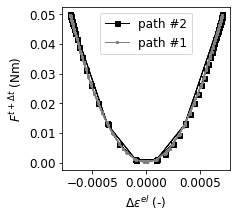

In [13]:
fig, ax = plt.subplots(1)
plt.plot(el_strain_tdt[n_reset:],
         energy_tdt[n_reset:],
         marker='s',markersize=5, linewidth=1, color='black',label='path #2')
plt.plot(el_strain_tdt[:n_reset],
         energy_tdt[:n_reset],
         marker='s',markersize=2, linewidth=1, color='gray',label='path #1')
ax.set_xlabel('$\Delta \epsilon^{el}$ (-)')
ax.set_ylabel('$F^{t+\Delta t}$ (Nm)')
ax.legend()